# Binomial (CRR) convergence and American early exercise

This demo shows how the Cox–Ross–Rubinstein (CRR) binomial model behaves as the number of time steps increases, and how the same tree supports **American early exercise**.

**You will:**
- Price a European call with **Black–Scholes** and with the **binomial tree**.
- Run a convergence experiment as the number of steps \(N\) increases.
- (Bonus) Compare **European vs American** puts and quantify the early-exercise premium.

> The demo uses the library’s public entrypoints: `bs_price(...)` and `binom_price(...)`.


## Setup

Imports and a small plotting helper. The notebook is robust: if an optional diagnostics plotting module is not present, it falls back to an inline implementation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from option_pricing import (
    MarketData,
    OptionSpec,
    OptionType,
    PricingInputs,
    binom_price,
    bs_price,
)
from option_pricing.diagnostics.binom.plots import (
    plot_binom_convergence_to_bs,  # type: ignore
)


## Inputs

We use one set of market inputs and price both a call and a put with the same strike and expiry.

In [2]:
# Base inputs used throughout the demo
market = MarketData(spot=100.0, rate=0.02, dividend_yield=0.0)

spec_call = OptionSpec(kind=OptionType.CALL, strike=100.0, expiry=1.0)
spec_put  = OptionSpec(kind=OptionType.PUT,  strike=100.0, expiry=1.0)

p_call = PricingInputs(spec=spec_call, market=market, sigma=0.20, t=0.0)
p_put  = PricingInputs(spec=spec_put,  market=market, sigma=0.20, t=0.0)

p_call, p_put


(PricingInputs(spec=OptionSpec(kind=<OptionType.CALL: 'call'>, strike=100.0, expiry=1.0), market=MarketData(spot=100.0, rate=0.02, dividend_yield=0.0), sigma=0.2, t=0.0),
 PricingInputs(spec=OptionSpec(kind=<OptionType.PUT: 'put'>, strike=100.0, expiry=1.0), market=MarketData(spot=100.0, rate=0.02, dividend_yield=0.0), sigma=0.2, t=0.0))

## Quick check: BS vs binomial (European call)

The binomial pricer has two European methods:
- `method='tree'`: backward induction (also supports American)
- `method='closed_form'`: fast binomial sum (European only)

For European options, both methods should agree (up to numerical tolerance) and converge towards Black–Scholes as \(N\) increases.

In [3]:
N = 200

bs = bs_price(p_call)
tree_price = binom_price(p_call, N, method="tree", american=False)
sum_price  = binom_price(p_call, N, method="closed_form", american=False)

print(f"Black–Scholes (call):        {bs:.6f}")
print(f"Binomial tree (N={N}):       {tree_price:.6f}")
print(f"Binomial closed-form (N={N}): {sum_price:.6f}")
print(f"|tree - BS|: {abs(tree_price - bs):.6g}")
print(f"|tree - sum|: {abs(tree_price - sum_price):.6g}")

# Sanity: European tree and closed-form should be close for the same N
assert abs(tree_price - sum_price) < 5e-3, "Tree and closed-form should match closely for European options."


Black–Scholes (call):        8.916037
Binomial tree (N=200):       8.906137
Binomial closed-form (N=200): 8.906137
|tree - BS|: 0.00990019
|tree - sum|: 1.77636e-15


## Convergence experiment

We compute the binomial price for a range of step counts \(N\) and compare to Black–Scholes. The absolute error typically decays as \(N\) increases.

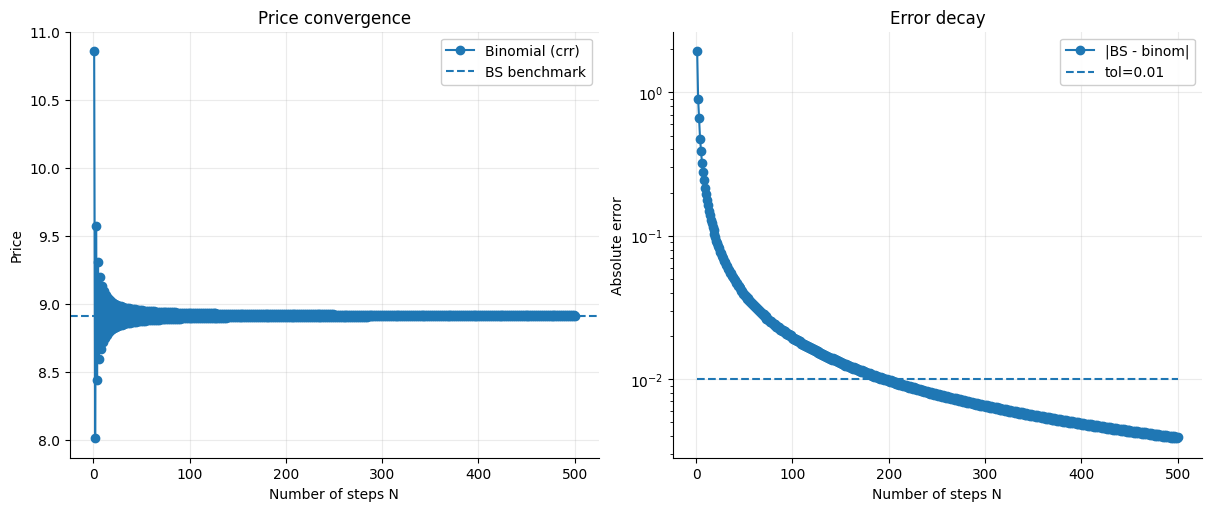

First N with abs error ≤ 0.01: N = 195


In [4]:
fig, (ax_price, ax_err), data = plot_binom_convergence_to_bs(
    p_call,
    n_steps=500,
    tol=1e-2,
    method="crr",
    err_scale="log",
)
plt.show()

# Small helper: smallest N achieving a given tolerance (if any)
tol = 1e-2
n_steps = data["n_steps"]
abs_err = np.asarray(data["abs_error"], dtype=float)

idx = np.where(abs_err <= tol)[0]
if idx.size > 0:
    n_star = int(n_steps[idx[0]])
    print(f"First N with abs error ≤ {tol:.2g}: N = {n_star}")
else:
    print(f"No N up to {int(n_steps.max())} achieved abs error ≤ {tol:.2g}.")


### Convergence table

A compact table is often easier to scan than a plot.

In [5]:
Ns = [5, 10, 25, 50, 100, 250, 500]
rows = []
bs_val = float(bs_price(p_call))

for n in Ns:
    price_n = float(binom_price(p_call, int(n), method="tree", american=False))
    rows.append((n, price_n, bs_val, abs(price_n - bs_val)))

df = pd.DataFrame(rows, columns=["N", "binom_tree", "bs_price", "abs_error"]).set_index("N")

# Pretty formatting for display
display(df.style.format({
    "binom_tree": "{:.6f}",
    "bs_price": "{:.6f}",
    "abs_error": "{:.6g}",
}))


,binom_tree,bs_price,abs_error
N,,,
5,9.308750,8.916037,0.392713
10,8.720683,8.916037,0.195354
25,8.993558,8.916037,0.077521
50,8.876513,8.916037,0.0395241
100,8.896250,8.916037,0.0197878
250,8.908116,8.916037,0.00792115
500,8.912076,8.916037,0.00396157


## Bonus: American put early-exercise premium

A key advantage of the tree method is that it supports early exercise. For non-dividend-paying stocks (\(q=0\)), an **American put** is typically worth more than the corresponding European put.

In [6]:
N = 300

euro_put = float(binom_price(p_put, N, american=False, method="tree"))
amer_put = float(binom_price(p_put, N, american=True, method="tree"))

premium = amer_put - euro_put

print(f"European put (tree, N={N}): {euro_put:.6f}")
print(f"American put  (tree, N={N}): {amer_put:.6f}")
print(f"Premium (Amer - Euro):      {premium:.6g}")

assert amer_put >= euro_put - 1e-12, "American option should be worth at least the European."


European put (tree, N=300): 6.929303
American put  (tree, N=300): 7.107052
Premium (Amer - Euro):      0.177749


### Premium vs number of steps

The estimated premium can vary with \(N\); increasing \(N\) typically stabilizes the result.

In [7]:
Ns = [25, 50, 100, 200, 300, 500]

rows = []
for n in Ns:
    euro = float(binom_price(p_put, int(n), american=False, method="tree"))
    amer = float(binom_price(p_put, int(n), american=True, method="tree"))
    rows.append((n, euro, amer, amer - euro))

prem_df = pd.DataFrame(rows, columns=["N", "euro_put", "amer_put", "premium"]).set_index("N")

display(prem_df.style.format({
    "euro_put": "{:.6f}",
    "amer_put": "{:.6f}",
    "premium": "{:.6g}",
}))


,euro_put,amer_put,premium
N,,,
25,7.013426,7.189874,0.176449
50,6.896380,7.087739,0.191358
100,6.916117,7.099470,0.183353
200,6.926004,7.105131,0.179126
300,6.929303,7.107052,0.177749
500,6.931943,7.108559,0.176616


## Takeaways

- For European options under GBM, **binomial prices converge** to Black–Scholes as the number of steps increases.
- The binomial implementation provides both:
  - a **tree** method (supports American exercise),
  - a **closed-form** binomial sum (European only, faster).
- For puts, **American ≥ European**, and the difference is the **early-exercise premium**.
